# Data

In [15]:
from util.config import latest_weights_file_path, get_config, get_eegnpy_test_file, get_labelnpy_test_file, get_imgnpy_test_file

config = get_config()
# CHANGE THIS CODE
model_name = "21chan_5st_120dp_20step"

config["datasource"] = f"./database/{model_name}"

map_data = {
    0 : 'Left Hand',
    1 : 'Right Hand',
    2 : 'Left Leg',
    3 : 'Tongue',
    4 : 'Right Leg'
}

classification_model = latest_weights_file_path(config)

In [16]:
from EEGImageDataset import EEGImageDataset
import torchvision

transform_eeg = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
transform_img = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
test_dataset = EEGImageDataset(
    eeg_path=get_eegnpy_test_file(config),
    images_path=get_imgnpy_test_file(config),
    labels_path=get_labelnpy_test_file(config), 
    transform_eeg=transform_eeg,
    transform_img=transform_img
)

# Classification Module

In [17]:
import torch

from model import EEGformer, build_eegformer
from trainer_eegformer_gen import ProjectionLayer, EEGImageGen

model = build_eegformer(
        channel_size=len(config["selected_channel"]),
        seq_len=config["seq_len"],
        N=config["transformer_size"],
        feature_onedcnn=120,
        kernel_size=9,
        h_regional=6,
        h_sync=6,
        h_temp=11,
        dropout=0.1,
        sub_matrices=6,
        feature_decoder=2,
        num_cls=5,
        scaler_ffn=4
    )

snapshot = torch.load(classification_model)
model.load_state_dict(snapshot["MODEL_STATE"])


/tmp/ipykernel_2824438/10276546.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snapshot = torch.load(classification_model)


<All keys matched successfully>

In [18]:
SAMPLE_INDEX_TEST = 100

In [19]:

data = test_dataset[SAMPLE_INDEX_TEST][0].to(torch.float32)
img = test_dataset[SAMPLE_INDEX_TEST][1].to(torch.float32)
truth_label = test_dataset[SAMPLE_INDEX_TEST][2]

output = model(data)
result_output = output.argmax().item()
print("Truth Label :", map_data[truth_label])
print("Classification Result : ", map_data[result_output])

Truth Label : Right Leg
Classification Result :  Right Leg


# Image Generation Module

In [20]:
from pathlib import Path
from model_vae import VAE
from trainer_eegformer_gen import EEGImageGen
config = get_config()


# ===================== VARIATIONAL AUTOENCODER CONFIGURATION =====================
local_config_vae = {
    "vae_model_folder" : "./database_vae/vae_weights",
    "vae_model_basename" : "vaemodel",
    "experiment_name" : "./database_vae/runs/vaemodel",
    "result_folder" : "./database_vae/results",
    "preload" : "latest" # or number that represent the epoch
}

def latest_weights_vae_file_path():
    model_folder = f"{local_config_vae['vae_model_folder']}"
    model_filename = f"{local_config_vae['vae_model_basename']}*"

    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None

    latest_file = ""
    latest_epoch = -1
    for file in weights_files:
        splitted = str(file).split("_")
        if (int(splitted[-1]) > latest_epoch):
            latest_epoch = int(splitted[-1])
            latest_file = file
    return str(latest_file)

def get_weights_vae_file_path(epoch: str):
    model_folder = f"{local_config_vae['vae_model_folder']}"
    model_filename = f"{local_config_vae['vae_model_basename']}_{epoch}"
    return str(Path('.') / model_folder / model_filename)


# ===================== PROJECTION LAYER CONFIGURATION =====================
local_config_projection = {
    "proj_model_folder" : f"./database_proj/{model_name}/proj_weights",
    "proj_model_basename" : "projmodel",
    "experiment_name" : f"./database_proj/({model_name})/runs/projmodel",
    "result_folder" : f"./database_proj/{model_name}/results",
    "preload" : "latest" # or number that represent the epoch
}

def latest_weights_proj_file_path():
    model_folder = f"{local_config_projection['proj_model_folder']}"
    model_filename = f"{local_config_projection['proj_model_basename']}*"

    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None

    latest_file = ""
    latest_epoch = -1
    for file in weights_files:
        splitted = str(file).split("_")
        if (int(splitted[-1]) > latest_epoch):
            latest_epoch = int(splitted[-1])
            latest_file = file
    return str(latest_file)

def get_weights_proj_file_path(epoch: str):
    model_folder = f"{local_config_projection['proj_model_folder']}"
    model_filename = f"{local_config_projection['proj_model_basename']}_{epoch}"
    return str(Path('.') / model_folder / model_filename)


# ===================== EEGFORMERIMAGE CONFIGURATION =====================
local_config_gen = {
    "gen_model_folder" : f'./database_gen/{model_name}/gen_weights',
    "gen_model_basename" : "genmodel",
    "experiment_name" : f"./database_gen/{model_name}/runs/genmodel",
    "result_folder" : f"./database_gen/{model_name}/results",
    "preload" : "latest" # or number that represent the epoch
}

def latest_weights_gen_file_path():
    model_folder = f"{local_config_gen['gen_model_folder']}"
    model_filename = f"{local_config_gen['gen_model_basename']}*"

    print(model_folder)
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None

    latest_file = ""
    latest_epoch = -1
    for file in weights_files:
        splitted = str(file).split("_")
        if (int(splitted[-1]) > latest_epoch):
            latest_epoch = int(splitted[-1])
            latest_file = file
    return str(latest_file)

def get_weights_gen_file_path(epoch: str):
    model_folder = f"{local_config_gen['gen_model_folder']}"
    model_filename = f"{local_config_gen['gen_model_basename']}_{epoch}"
    return str(Path('.') / model_folder / model_filename)

./database_gen/21chan_5st_120dp_20step/gen_weights
database_gen/21chan_5st_120dp_20step/gen_weights/genmodel_80


/tmp/ipykernel_2824438/1516815228.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snapshot_gen = torch.load(model_gen_fn)
/tmp/ipykernel_2824438/1516815228.py:15: Future

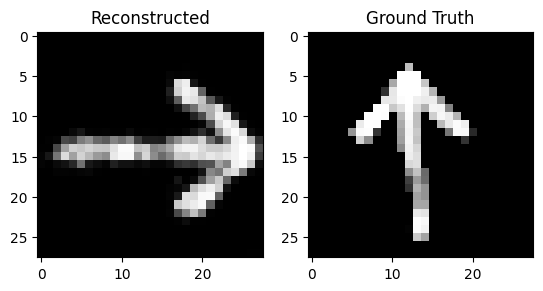

In [21]:
import matplotlib.pyplot as plt

# EEGformer & Projection Only
model_proj = ProjectionLayer()
model_gen = EEGImageGen(model, model_proj)

model_gen_fn = latest_weights_gen_file_path()
print(model_gen_fn)
snapshot_gen = torch.load(model_gen_fn)
model_gen.load_state_dict(snapshot_gen["MODEL_STATE"])

# Pretrained Variational Autoencoder
model_vae = VAE()
model_vae_fn = latest_weights_vae_file_path()
snapshot_vae = torch.load(model_vae_fn)
model_vae.load_state_dict(snapshot_vae["MODEL_STATE"])

output_latent = model_gen(data)
recon_image = model_vae.decode(output_latent)

source_image_unflat = img.squeeze().detach().cpu()
recon_image_unflat = recon_image.squeeze().detach().cpu()


plt.subplot(1,2,1)
plt.imshow(recon_image_unflat, cmap='gray')
plt.title("Reconstructed")

plt.subplot(1,2,2)
plt.imshow(source_image_unflat, cmap='gray')
plt.title("Ground Truth")

plt.show();